## Create INNER Grid from NEXRAD WSR-88D KICT

In [1]:
%matplotlib inline

In [28]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator
from matplotlib.colors import BoundaryNorm

from pyart.io import read
from pyart.graph import cm
from pyart.filters import GateFilter
from pyart.correct import dealias_region_based

from grid.interp import mapper
from grid.core import Weight, Domain

### Helper functions

In [3]:
def _plot_ppi(radar, field, sweep=0, max_range=100.0, cmap=None, norm=None, ticks=None, fig=None, ax=None):
    """
    """
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    
    # Parse radar sweep coordinates
    _range = radar.range['data'] / 1000.0
    azimuth = np.radians(radar.get_azimuth(sweep))
    idx = np.abs(_range - max_range).argmin()
    
    # Compute (x, y) coordinates
    AZI, RNG = np.meshgrid(azimuth, _range[:idx+1], indexing='ij')
    X = RNG * np.sin(AZI)
    Y = RNG * np.cos(AZI)
    
    # Parse radar field data
    data = radar.get_field(sweep, field)[:,:idx+1]
    
    # Create quadmesh
    qm = ax.pcolormesh(
        X, Y, data, cmap=cmap, norm=norm, alpha=None, shading='flat', rasterized=True)
    
    # Create colour bar
    fig.colorbar(mappable=qm, ax=ax, orientation='vertical', ticks=ticks)
    
    # Set title
    title = '{} {:.1f} deg\n{}'.format(
        radar.metadata['instrument_name'], radar.fixed_angle['data'][sweep], field)
    ax.set_title(title)
    
    return

In [4]:
def _plot_cappi(grid, field, height=0, scale=1.0, cmap=None, norm=None, ticks=None, fig=None, ax=None):
    """
    """
    # Parse figure and axis
    if fig is None:
        fig = plt.gcf()
    if ax is None:
        ax = plt.gca()
    
    # Parse grid coordinates
    x_disp = grid.axes['x_disp']['data'] / 1000.0
    y_disp = grid.axes['y_disp']['data'] / 1000.0
    z_disp = grid.axes['z_disp']['data'] / 1000.0
    
    # Create quadmesh
    qm = ax.pcolormesh(
        x_disp, y_disp, scale * grid.fields[field]['data'][height], cmap=cmap, 
        norm=norm, alpha=None, shading='flat', rasterized=True)
    
    # Create colour bar
    fig.colorbar(mappable=qm, ax=ax, orientation='vertical', ticks=ticks)
    
    # Set title
    title = '{:.1f} km\n{}'.format(z_disp[height], field)
    ax.set_title(title)
    
    return

#### Format colour maps

In [46]:
# Define colour maps
cmap_refl = cm.NWSRef
cmap_vdop = cm.NWSVel
cmap_spw = cm.NWS_SPW
cmap_gqi = cm.Carbone17
cmap_dist = cm.BlueBrown10
cmap_weight = cm.Carbone17
cmap_time = cm.BlueBrown10

# Normalize colour maps
norm_refl = BoundaryNorm(np.arange(-10, 65, 5), cmap_refl.N)
norm_vdop = BoundaryNorm(np.arange(-30, 32, 2), cmap_vdop.N)
norm_spw = BoundaryNorm(np.arange(0, 8.5, 0.5), cmap_spw.N)
norm_gqi = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_gqi.N)
norm_dist = BoundaryNorm(np.arange(0, 2.1, 0.1), cmap_dist.N)
norm_weight = BoundaryNorm(np.arange(0, 1.05, 0.05), cmap_weight.N)
norm_time = BoundaryNorm(np.arange(0, 250, 10), cmap_time.N)

# Define colour bar ticks
ticks_refl = np.arange(-10, 70, 10)
ticks_vdop = np.arange(-30, 40, 10)
ticks_spw = np.arange(0, 9, 1)
ticks_gqi = np.arange(0, 1.2, 0.2)
ticks_dist = np.arange(0, 2.4, 0.4)
ticks_weight = np.arange(0, 1.2, 0.2)
ticks_time = np.arange(0, 280, 40)

#### Read radar data

In [6]:
filename = '/net/hydra/storage/common_data/MC3E/raw_data/nexrad_data/KICT20110520_100015_V03.gz'
radar = read(filename, exclude_fields=None)

In [7]:
# List available fields
for field in radar.fields.keys():
    print field

velocity
spectrum_width
reflectivity


#### Plot PPI data

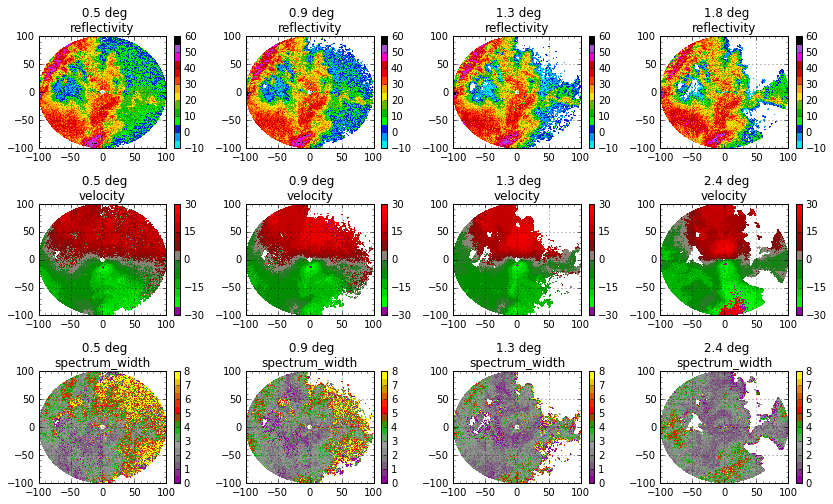

In [8]:
figs = {'figsize': (14, 8)}
subs = {'xlim': (-100, 100), 'ylim': (-100, 100)}
fig, axes = plt.subplots(nrows=3, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.3, hspace=0.5)

sweeps = [0, 2, 4, 6]

for i, sweep in enumerate(sweeps):
    
    # (a) Reflectivity
    _plot_ppi(radar, 'reflectivity', sweep=sweep, cmap=cmap_refl, 
              norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Doppler velocity
    _plot_ppi(radar, 'velocity', sweep=sweep+1, cmap=cmap_vdop, 
              norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[1,i])
    
    # (c) Spectrum width
    _plot_ppi(radar, 'spectrum_width', sweep=sweep+1, cmap=cmap_spw, 
              norm=norm_spw, ticks=ticks_spw, fig=fig, ax=axes[2,i])
    
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(50))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(50))
    ax.yaxis.set_minor_locator(MultipleLocator(10))
    ax.grid(which='major')

### Create quick gate filter

The GateFilter is used during Doppler velocity dealiasing and during radar data mapping to determine the grid quality index.

In [29]:
gf = GateFilter(radar)
gf.exclude_masked('reflectivity')

### Dealias radial velocities

In [30]:
vdop_corr = dealias_region_based(
    radar, gatefilter=gf, interval_splits=5, interval_limits=None,
    skip_between_rays=20, skip_along_ray=20, centered=True,
    keep_original=False, nyquist_vel=None, check_nyquist_uniform=True,
    rays_wrap_around=True, set_limits=False)
radar.add_field('corrected_velocity', vdop_corr, replace_existing=True)

/aos/home/kirk/projects/pyart/pyart/correct/region_dealias.py:241: UserWarning: Velocities outside of the Nyquist interval found in sweep 6.
  warnings.warn(msg, UserWarning)
/aos/home/kirk/projects/pyart/pyart/correct/region_dealias.py:241: UserWarning: Velocities outside of the Nyquist interval found in sweep 7.
  warnings.warn(msg, UserWarning)
/aos/home/kirk/projects/pyart/pyart/correct/region_dealias.py:241: UserWarning: Velocities outside of the Nyquist interval found in sweep 8.
  warnings.warn(msg, UserWarning)
/aos/home/kirk/projects/pyart/pyart/correct/region_dealias.py:241: UserWarning: Velocities outside of the Nyquist interval found in sweep 9.
  warnings.warn(msg, UserWarning)
/aos/home/kirk/projects/pyart/pyart/correct/region_dealias.py:241: UserWarning: Velocities outside of the Nyquist interval found in sweep 10.
  warnings.warn(msg, UserWarning)
/aos/home/kirk/projects/pyart/pyart/correct/region_dealias.py:241: UserWarning: Velocities outside of the Nyquist interval f

### Grid radar data

In [35]:
# Define grid coordinates coordinates
coords = [
    np.arange(0.0, 10500.0, 500.0),
    np.arange(-25000.0, 100500.0, 500.0),
    np.arange(-50000.0, 50500.0, 500.0)
    ]

# Define grid origin
origin = (36.605, -97.485, None)

# Define fields to grid
fields = [
    'reflectivity', 
    'velocity',
    'spectrum_width',
    'corrected_velocity',
    ]

In [36]:
# Create grid domain
domain = Domain(coords, origin, proj='lcca', ellps='WGS84', datum='WGS84', dem=None)

#### Nearest neighbour

In [37]:
grid = mapper.grid_radar_nearest_neighbour(
    radar, domain, fields=fields, gatefilter=gf, toa=17000.0, max_range=None, 
    leafsize=10, legacy=True, debug=True, verbose=True)

Radar x in grid: 3.70 km
Radar y in grid: 116.47 km
Radar z in grid: 0.00 km
Number of radar gates before pruning: 15168960
Number of radar gates below TOA: 9603276
Creating k-d tree instance for radar gate locations
tree.m = 3
tree.n = 9603276
Number of x grid points: 201
Number of y grid points: 251
Number of z grid points: 21
Grid 1-D array shape: (1059471,)
Querying k-d tree for the k-nearest analysis grid points
Distance array shape: (1059471,)
Minimum gate-grid distance: 3.29 m
Maximum gate-grid distance: 3873.80 m
Index array shape: (1059471,)
Minimum index: 38185
Maximum index: 9564027
Number of analysis points too far from radar: 0
Mapping radar field: reflectivity
Mapping radar field: velocity
Mapping radar field: spectrum_width
Mapping radar field: corrected_velocity


/aos/home/kirk/projects/pyart/pyart/core/grid.py:181: DeprecationWarning: from_legacy_parameters is depreciated and will be removed in a future version of Py-ART
  "future version of Py-ART", DeprecationWarning)


In [40]:
# Print available gridded fields
for field in grid.fields.keys():
    print field

grid_quality_index
spectrum_width
reflectivity
nearest_neighbor_distance
corrected_velocity
velocity
nearest_neighbor_time


#### Plot nearest neighbour results

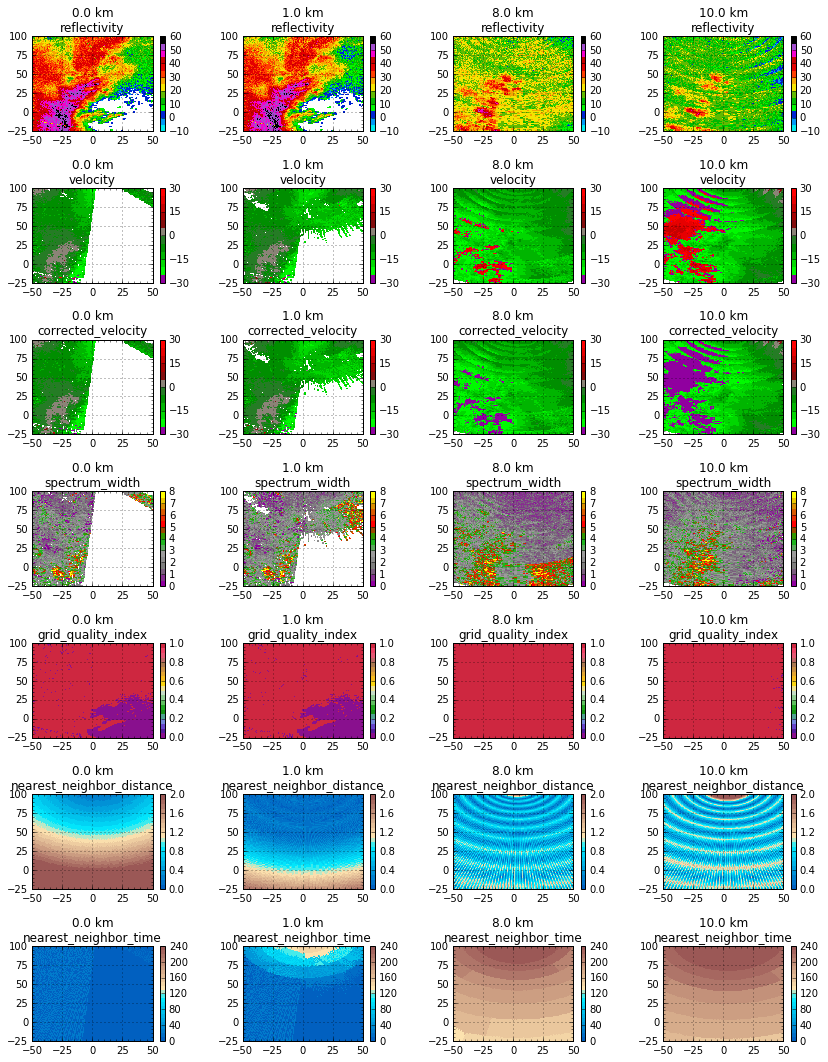

In [42]:
figs = {'figsize': (14, 18)}
subs = {'xlim': (-50, 50), 'ylim': (-25, 100)}
fig, axes = plt.subplots(nrows=7, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.4, hspace=0.6)

heights = [0, 2, 16, 20]

for i, height in enumerate(heights):
    
    # (a) Reflectivity
    _plot_cappi(grid, 'reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Doppler velocity
    _plot_cappi(grid, 'velocity', height=height, cmap=cmap_vdop, 
                norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[1,i])
    
    # (c) Corrected Doppler velocity
    _plot_cappi(grid, 'corrected_velocity', height=height, cmap=cmap_vdop, 
                norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[2,i])
    
    # (d) Spectrum width
    _plot_cappi(grid, 'spectrum_width', height=height, cmap=cmap_spw,
                norm=norm_spw, ticks=ticks_spw, fig=fig, ax=axes[3,i])
    
    # (e) Grid quality index
    _plot_cappi(grid, 'grid_quality_index', height=height, cmap=cmap_gqi,
                norm=norm_gqi, ticks=ticks_gqi, fig=fig, ax=axes[4,i])
    
    # (f) Nearest neighbour distance
    _plot_cappi(grid, 'nearest_neighbor_distance', height=height, scale=1.0e-3, 
                cmap=cmap_dist, norm=norm_dist, ticks=ticks_dist, fig=fig, 
                ax=axes[5,i])
    
    # (g) Nearest neighbour time
    _plot_cappi(grid, 'nearest_neighbor_time', height=height, cmap=cmap_time, 
                norm=norm_time, ticks=ticks_time, fig=fig, ax=axes[6,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(25))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')

#### Isotropic Barnes

In [43]:
# Define the weight
weight = Weight(func=None, cutoff_radius=np.inf, k=100, kappa_star=0.5, data_spacing=1000.0)
weight.compute_distance_weight_vanishes(atol=0.001, verbose=True)

Distance weight vanishes: 3750.00 m


In [44]:
grid = mapper.grid_radar(
    radar, domain, weight=weight, fields=fields, gatefilter=gf, toa=17000.0, 
    max_range=None, legacy=True, debug=True, verbose=True)

Radar x in grid: 3.70 km
Radar y in grid: 116.47 km
Radar z in grid: 0.00 km
Number of radar gates before pruning: 15168960
Number of radar gates below TOA: 9603276
Number of x grid points: 201
Number of y grid points: 251
Number of z grid points: 21
Grid 1-D array shape: (1059471,)
No radar kd-tree exists
Creating k-d tree instance for radar gate locations
tree.m = 3
tree.n = 9603276
Querying k-d tree for the k-nearest analysis grid points
Elapsed time for query: 27.47 sec
Distance array shape: (1059471, 100)
Minimum gate-grid distance: 3.29 m
Maximum gate-grid distance: 4163.60 m
Index array shape: (1059471, 100)
Minimum index: 34555
Maximum index: 9564810
Computing distance-dependent weights
Number of invalid indices: 0
Number of analysis points too far from radar: 0
Mapping radar field: reflectivity
Mapping radar field: velocity
Mapping radar field: spectrum_width
Mapping radar field: corrected_velocity


/aos/home/kirk/projects/pyart/pyart/core/grid.py:181: DeprecationWarning: from_legacy_parameters is depreciated and will be removed in a future version of Py-ART
  "future version of Py-ART", DeprecationWarning)


In [24]:
# Print available gridded fields
for field in grid.fields.keys():
    print field

nearest_neighbor_weight
grid_quality_index
spectrum_width
reflectivity
nearest_neighbor_distance
velocity
nearest_neighbor_time


#### Plot Barnes results

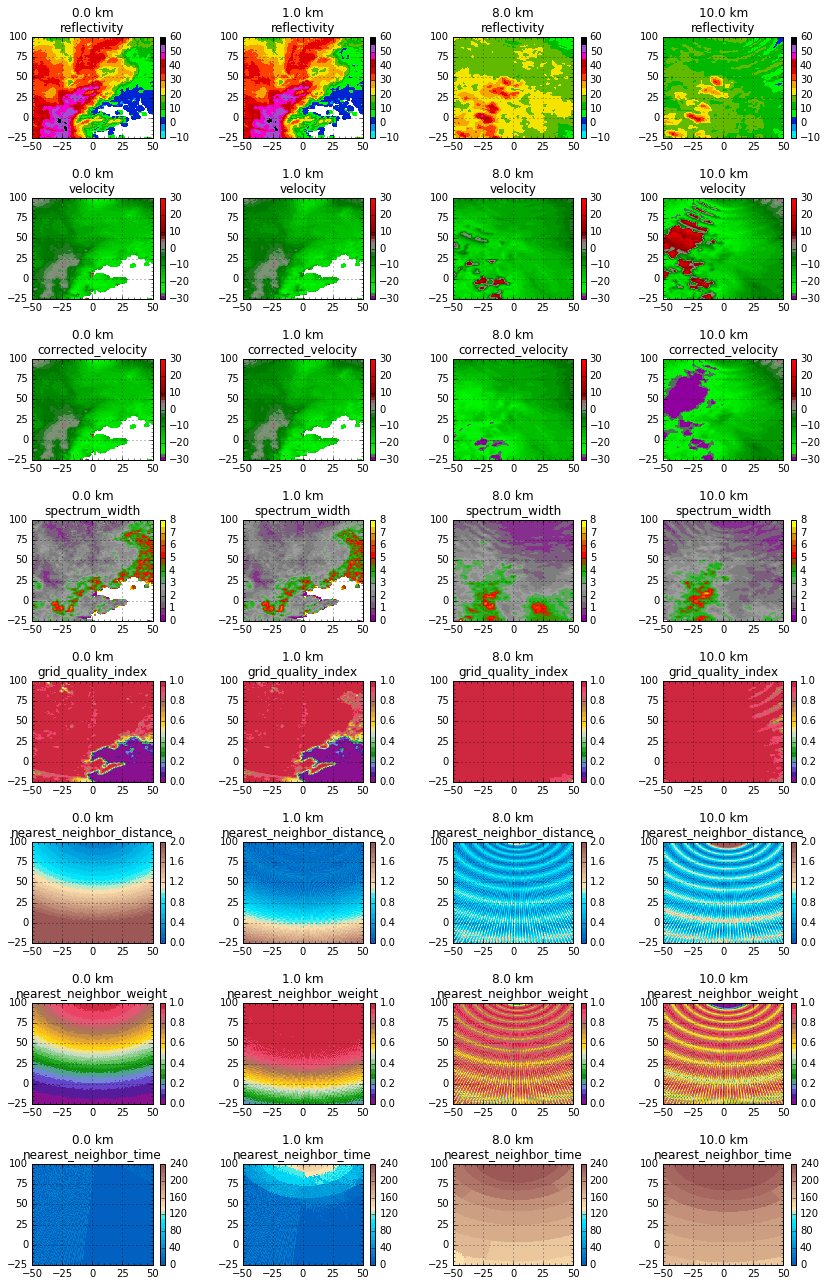

In [47]:
figs = {'figsize': (14, 22)}
subs = {'xlim': (-50, 50), 'ylim': (-25, 100)}
fig, axes = plt.subplots(nrows=8, ncols=4, subplot_kw=subs, **figs)
fig.subplots_adjust(wspace=0.4, hspace=0.6)

heights = [0, 2, 16, 20]

for i, height in enumerate(heights):
    
    # (a) Reflectivity
    _plot_cappi(grid, 'reflectivity', height=height, cmap=cmap_refl, 
                norm=norm_refl, ticks=ticks_refl, fig=fig, ax=axes[0,i])
    
    # (b) Doppler velocity
    _plot_cappi(grid, 'velocity', height=height, cmap=cmap_vdop, 
                norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[1,i])
    
    # (c) Corrected Doppler velocity
    _plot_cappi(grid, 'corrected_velocity', height=height, cmap=cmap_vdop, 
                norm=norm_vdop, ticks=ticks_vdop, fig=fig, ax=axes[2,i])
    
    # (d) Spectrum width
    _plot_cappi(grid, 'spectrum_width', height=height, cmap=cmap_spw,
                norm=norm_spw, ticks=ticks_spw, fig=fig, ax=axes[3,i])
    
    # (e) Grid quality index
    _plot_cappi(grid, 'grid_quality_index', height=height, cmap=cmap_gqi,
                norm=norm_gqi, ticks=ticks_gqi, fig=fig, ax=axes[4,i])
    
    # (f) Nearest neighbour distance
    _plot_cappi(grid, 'nearest_neighbor_distance', height=height, scale=1.0e-3, 
                cmap=cmap_dist, norm=norm_dist, ticks=ticks_dist, fig=fig, 
                ax=axes[5,i])
    
    # (g) Nearest neighbour weight
    _plot_cappi(grid, 'nearest_neighbor_weight', height=height, cmap=cmap_weight, 
                norm=norm_weight, ticks=ticks_weight, fig=fig, ax=axes[6,i])
    
    # (h) Nearest neighbour time
    _plot_cappi(grid, 'nearest_neighbor_time', height=height, cmap=cmap_time, 
                norm=norm_time, ticks=ticks_time, fig=fig, ax=axes[7,i])

# Format axes
for ax in axes.flat:
    ax.xaxis.set_major_locator(MultipleLocator(25))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_major_locator(MultipleLocator(25))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.grid(which='major')